In [165]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from torchvision.models import resnet18


from captum.attr import IntegratedGradients
from captum.attr import GradientShap
from captum.attr import Occlusion
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable


In [166]:
# Default device plus free memory
torch.cuda.empty_cache()
#device = "cpu"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [167]:
""" # Modify ResNet-18 for MNIST
model = resnet18(pretrained=False)
# Change the input layer to accept grayscale images
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
# Adjust the final layer to output 10 classes
model.fc = nn.Linear(model.fc.in_features, 10)

# Load the saved state_dict
model.load_state_dict(torch.load('./Models/resnet18_mnist.pth'))

# Move model to device and set to evaluation mode
model = model.to(device).eval() """

" # Modify ResNet-18 for MNIST\nmodel = resnet18(pretrained=False)\n# Change the input layer to accept grayscale images\nmodel.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)\n# Adjust the final layer to output 10 classes\nmodel.fc = nn.Linear(model.fc.in_features, 10)\n\n# Load the saved state_dict\nmodel.load_state_dict(torch.load('./Models/resnet18_mnist.pth'))\n\n# Move model to device and set to evaluation mode\nmodel = model.to(device).eval() "

In [168]:
class Net(nn.Module):
    def __init__(self, chanels, kernel_size):
        super(Net, self).__init__()
        
        # First block
        self.conv1 = nn.Conv2d(1, chanels, kernel_size, padding=kernel_size//2)
        self.bn1 = nn.BatchNorm2d(chanels)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2)
        
        # Second block
        self.conv2 = nn.Conv2d(chanels, 2 * chanels, kernel_size, padding=kernel_size//2)
        self.bn2 = nn.BatchNorm2d(2 * chanels)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2)
        
        # Third block
        self.conv3 = nn.Conv2d(2*chanels, 4 * chanels, kernel_size, padding=kernel_size//2)
        self.bn3 = nn.BatchNorm2d(4 * chanels)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(2)
        
        # Fourth block (no pooling after this)
        self.conv4 = nn.Conv2d(4*chanels, 8 * chanels, kernel_size, padding=kernel_size//2)
        self.bn4 = nn.BatchNorm2d(8 * chanels)
        self.relu4 = nn.ReLU()
        
        # Global Average Pooling
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)

        # Fully connected layers
        self.fc1 = nn.Linear(8*chanels, 128)
        self.drop1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 10)  # 10 classes for MNIST

    def forward(self, x):
        x = self.pool1(self.relu1(self.bn1(self.conv1(x))))
        x = self.pool2(self.relu2(self.bn2(self.conv2(x))))
        x = self.pool3(self.relu3(self.bn3(self.conv3(x))))
        x = self.relu4(self.bn4(self.conv4(x)))
        
        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor

        x = self.drop1(F.relu(self.fc1(x)))
        x = self.fc2(x) 
        
        return x

In [169]:
# Instantiate the model
chanels = 32
kernel_size = 3
model = Net(chanels, kernel_size)

# Load the weights
model.load_state_dict(torch.load("./Models/custom_cnn_mnist.pth"))
model.eval()  # Set the model to evaluation mode

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu4): ReLU

In [170]:
# Apply resize and normalization to the images
transform = transforms.Compose([
    # transforms.Resize((224, 224)), used for resnet18
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Download the MNIST dataset
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)

In [171]:
chosen_digit = 'all_digits'
# Pick two images for each digit
selected_images = {i: [] for i in range(10)}
selected_labels = {i: [] for i in range(10)}

for image, label in test_dataset:
    if len(selected_images[label]) < 2:
        selected_images[label].append(image)
        selected_labels[label].append(label)

    # Break if we have collected 2 images for each digit
    if all(len(images) == 2 for images in selected_images.values()):
        break

# Verification
for digit, images in selected_images.items():
    print(f"For digit {digit}, selected {len(images)} images.")

For digit 0, selected 2 images.
For digit 1, selected 2 images.
For digit 2, selected 2 images.
For digit 3, selected 2 images.
For digit 4, selected 2 images.
For digit 5, selected 2 images.
For digit 6, selected 2 images.
For digit 7, selected 2 images.
For digit 8, selected 2 images.
For digit 9, selected 2 images.


In [172]:
""" # Choose a specific digit
chosen_digit = 9

# Initialize dictionary for the chosen digit
selected_images = {chosen_digit: []}
selected_labels = {chosen_digit: []}

for image, label in test_dataset:
    if label == chosen_digit and len(selected_images[label]) < 20:
        selected_images[label].append(image)
        selected_labels[label].append(label)

    # Break if we have collected 20 images for the chosen digit
    if len(selected_images[chosen_digit]) == 20:
        break

# Verification
print(f"For digit {chosen_digit}, selected {len(selected_images[chosen_digit])} images.") """

For digit 9, selected 20 images.


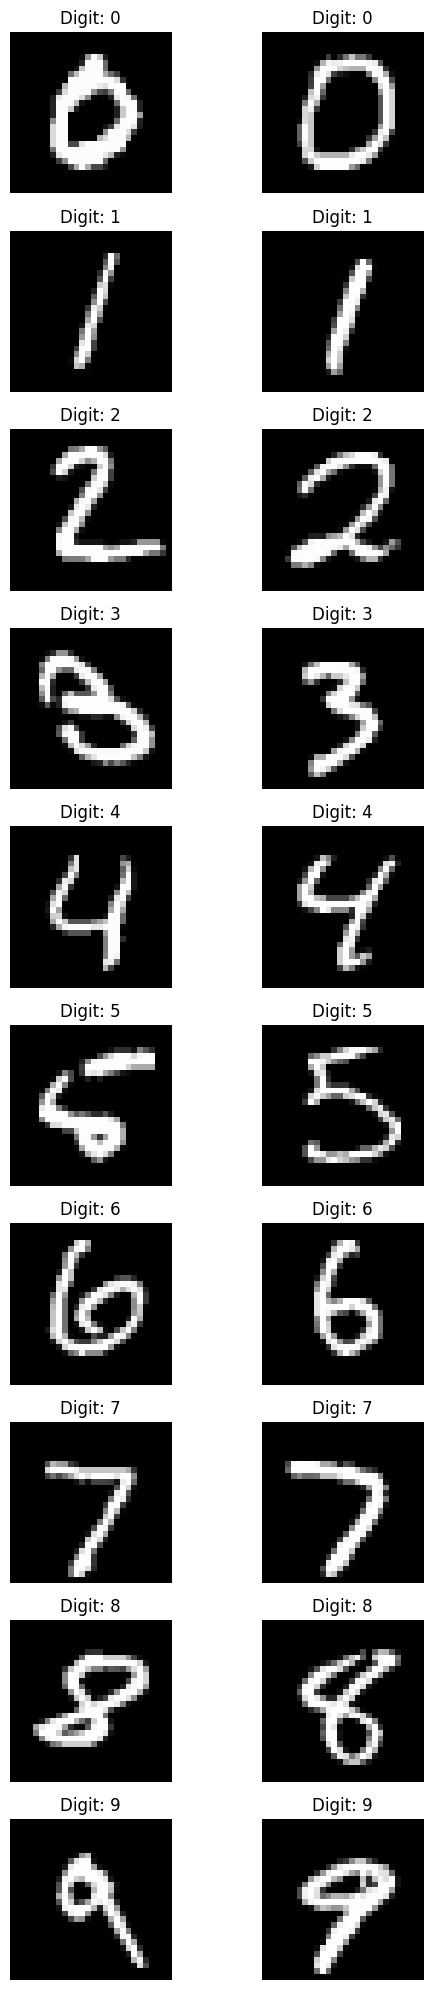

In [173]:
""" # Setting up a 10x2 grid of subplots
fig, axes = plt.subplots(nrows=10, ncols=2, figsize=(6, 20))

# Iterating through the digits
for digit, images in selected_images_every_digit.items():
    for idx, image in enumerate(images):
        ax = axes[digit, idx]
        # Since the images are normalized, we denormalize them for visualization
        image_denormalized = image * 0.5 + 0.5
        ax.imshow(image_denormalized.squeeze().numpy(), cmap='gray')
        ax.set_title(f"Digit: {digit}")
        ax.axis('off')  # Hiding axis labels

_ = plt.tight_layout()
_ = plt.show() """

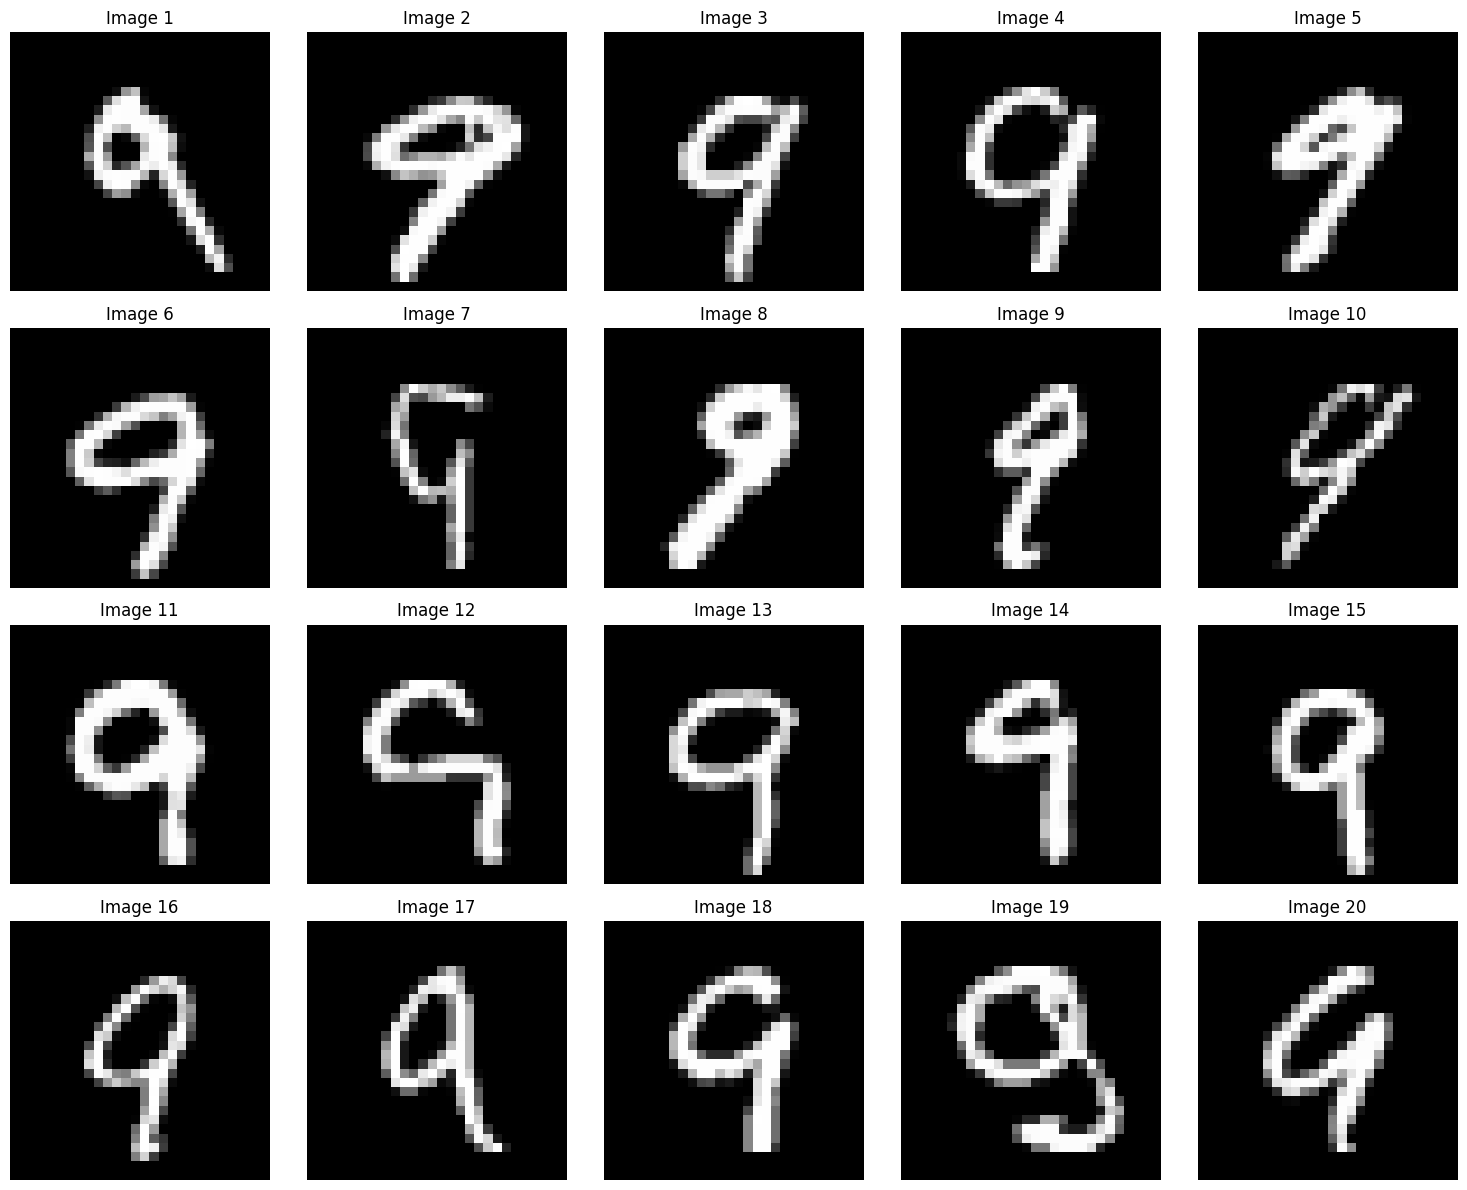

In [174]:
""" # Plot each of the selected images for the chosen digit
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(15, 12))  # 4 rows and 5 columns to plot 20 images

for idx, image in enumerate(selected_images[chosen_digit]):
    row_idx = idx // 5
    col_idx = idx % 5
    img_reshaped = image.squeeze().numpy()  # Convert tensor to numpy array and remove any singleton dimensions
    axes[row_idx, col_idx].imshow(img_reshaped, cmap='gray')
    axes[row_idx, col_idx].set_title(f"Image {idx+1}")
    axes[row_idx, col_idx].axis('off')

plt.tight_layout()
plt.show() """

In [175]:
# To store results for all images
results = []

# Iterate over digits and their corresponding images
for digit, images in selected_images.items():
    for idx, image in enumerate(images):
        # Add batch dimension and run the model
        with torch.no_grad():
            image = image.unsqueeze(0)  # Add batch dimension
            output = model(image)
            predicted_label = torch.argmax(output).item()
            probabilities = F.softmax(output, dim=1)  # Apply softmax to get the probabilities
            prediction_score = probabilities[0][predicted_label].item()  # Confidence score for the predicted label
        
        # Store the results
        result = {
            "True Label": digit,
            "Predicted Label": predicted_label,
            "Confidence Score": prediction_score,
            "Probability Distribution": probabilities[0].tolist()
        }
        results.append(result)

# Displaying the results
for res in results:
    print(f"True Label: {res['True Label']}")
    print(f"Predicted Label: {res['Predicted Label']}")
    print(f"Confidence Score for the Predicted Label: {res['Confidence Score']:.4f}")
    print(f"Probability Distribution over Classes: {res['Probability Distribution']}")
    print("="*50)

True Label: 9
Predicted Label: 9
Confidence Score for the Predicted Label: 1.0000
Probability Distribution over Classes: [2.4268103970825905e-08, 5.719592577335675e-10, 2.9495254239009228e-08, 2.4358638484045514e-07, 5.773747489001835e-07, 6.320147605265447e-08, 1.5886015836130696e-09, 6.083315895466512e-08, 3.004834070452489e-07, 0.9999985694885254]
True Label: 9
Predicted Label: 9
Confidence Score for the Predicted Label: 0.9999
Probability Distribution over Classes: [3.987999708243706e-09, 6.008073483165788e-10, 6.2883569462712785e-09, 1.751775435820946e-08, 3.146114613628015e-05, 2.9872155860033445e-09, 1.253155246239146e-09, 6.822976047260454e-06, 2.536740794312209e-05, 0.9999363422393799]
True Label: 9
Predicted Label: 9
Confidence Score for the Predicted Label: 1.0000
Probability Distribution over Classes: [1.3807551768607595e-09, 4.4052533842986463e-10, 3.725920905139901e-09, 3.071588992042962e-07, 5.653990342580073e-07, 2.1698156160709914e-08, 5.244972858808872e-11, 7.15391797

# Integrated Gradients with Captum

**Integrated Gradients** is an interpretability technique used in the field of deep learning. It is designed to provide insights into the importance of each feature in influencing the model's predictions. This method is part of the `Captum` library, which offers a suite of algorithms to provide model interpretability and understanding.

## Overview

Integrated Gradients aims to attribute the prediction of a neural network to its input features. It does this by capturing the gradients of the model's output with respect to its inputs and then integrating these gradients over a straight-line path from a baseline input to the actual input.

## Method Goals and Functionality

- **Transparency**: Offers a clearer understanding of the model's decision-making process.
- **Feature Importance**: Identifies which input features are most influential for a given prediction.
- **Consistency**: Provides consistent attributions that offer insights across different models with the same architecture.

In [176]:
integrated_gradients = IntegratedGradients(model)

# Store the attributions for each image
attributions_list = []

# Iterate over images and results
for (digit, images), res in zip(selected_images.items(), results):
    for idx, image in enumerate(images):
        predicted_label = res["Predicted Label"]  # Retrieve the predicted label from results
        transformed_img = image.unsqueeze(0)  # Add batch dimension and send to device

        # Compute the attributions using Integrated Gradients
        attributions_ig = integrated_gradients.attribute(transformed_img, target=predicted_label, n_steps=20)
        attributions_list.append(attributions_ig)

/tmp/ipykernel_3275/3935895928.py:35: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  _ = plt.savefig(f'./AttributionsMaps/Digits/integrated_gradients_{chosen_digit}.png', bbox_inches='tight', dpi=300)
/tmp/ipykernel_3275/3935895928.py:35: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  _ = plt.savefig(f'./AttributionsMaps/Digits/integrated_gradients_{chosen_digit}.png', bbox_inches='tight', dpi=300)
/tmp/ipykernel_3275/3935895928.py:35: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  _ = plt.savefig(f'./AttributionsMaps/Digits/integrated_gradients_{chosen_digit}.png', bbox_inches='tight', dpi=300)
/tmp/ipyker

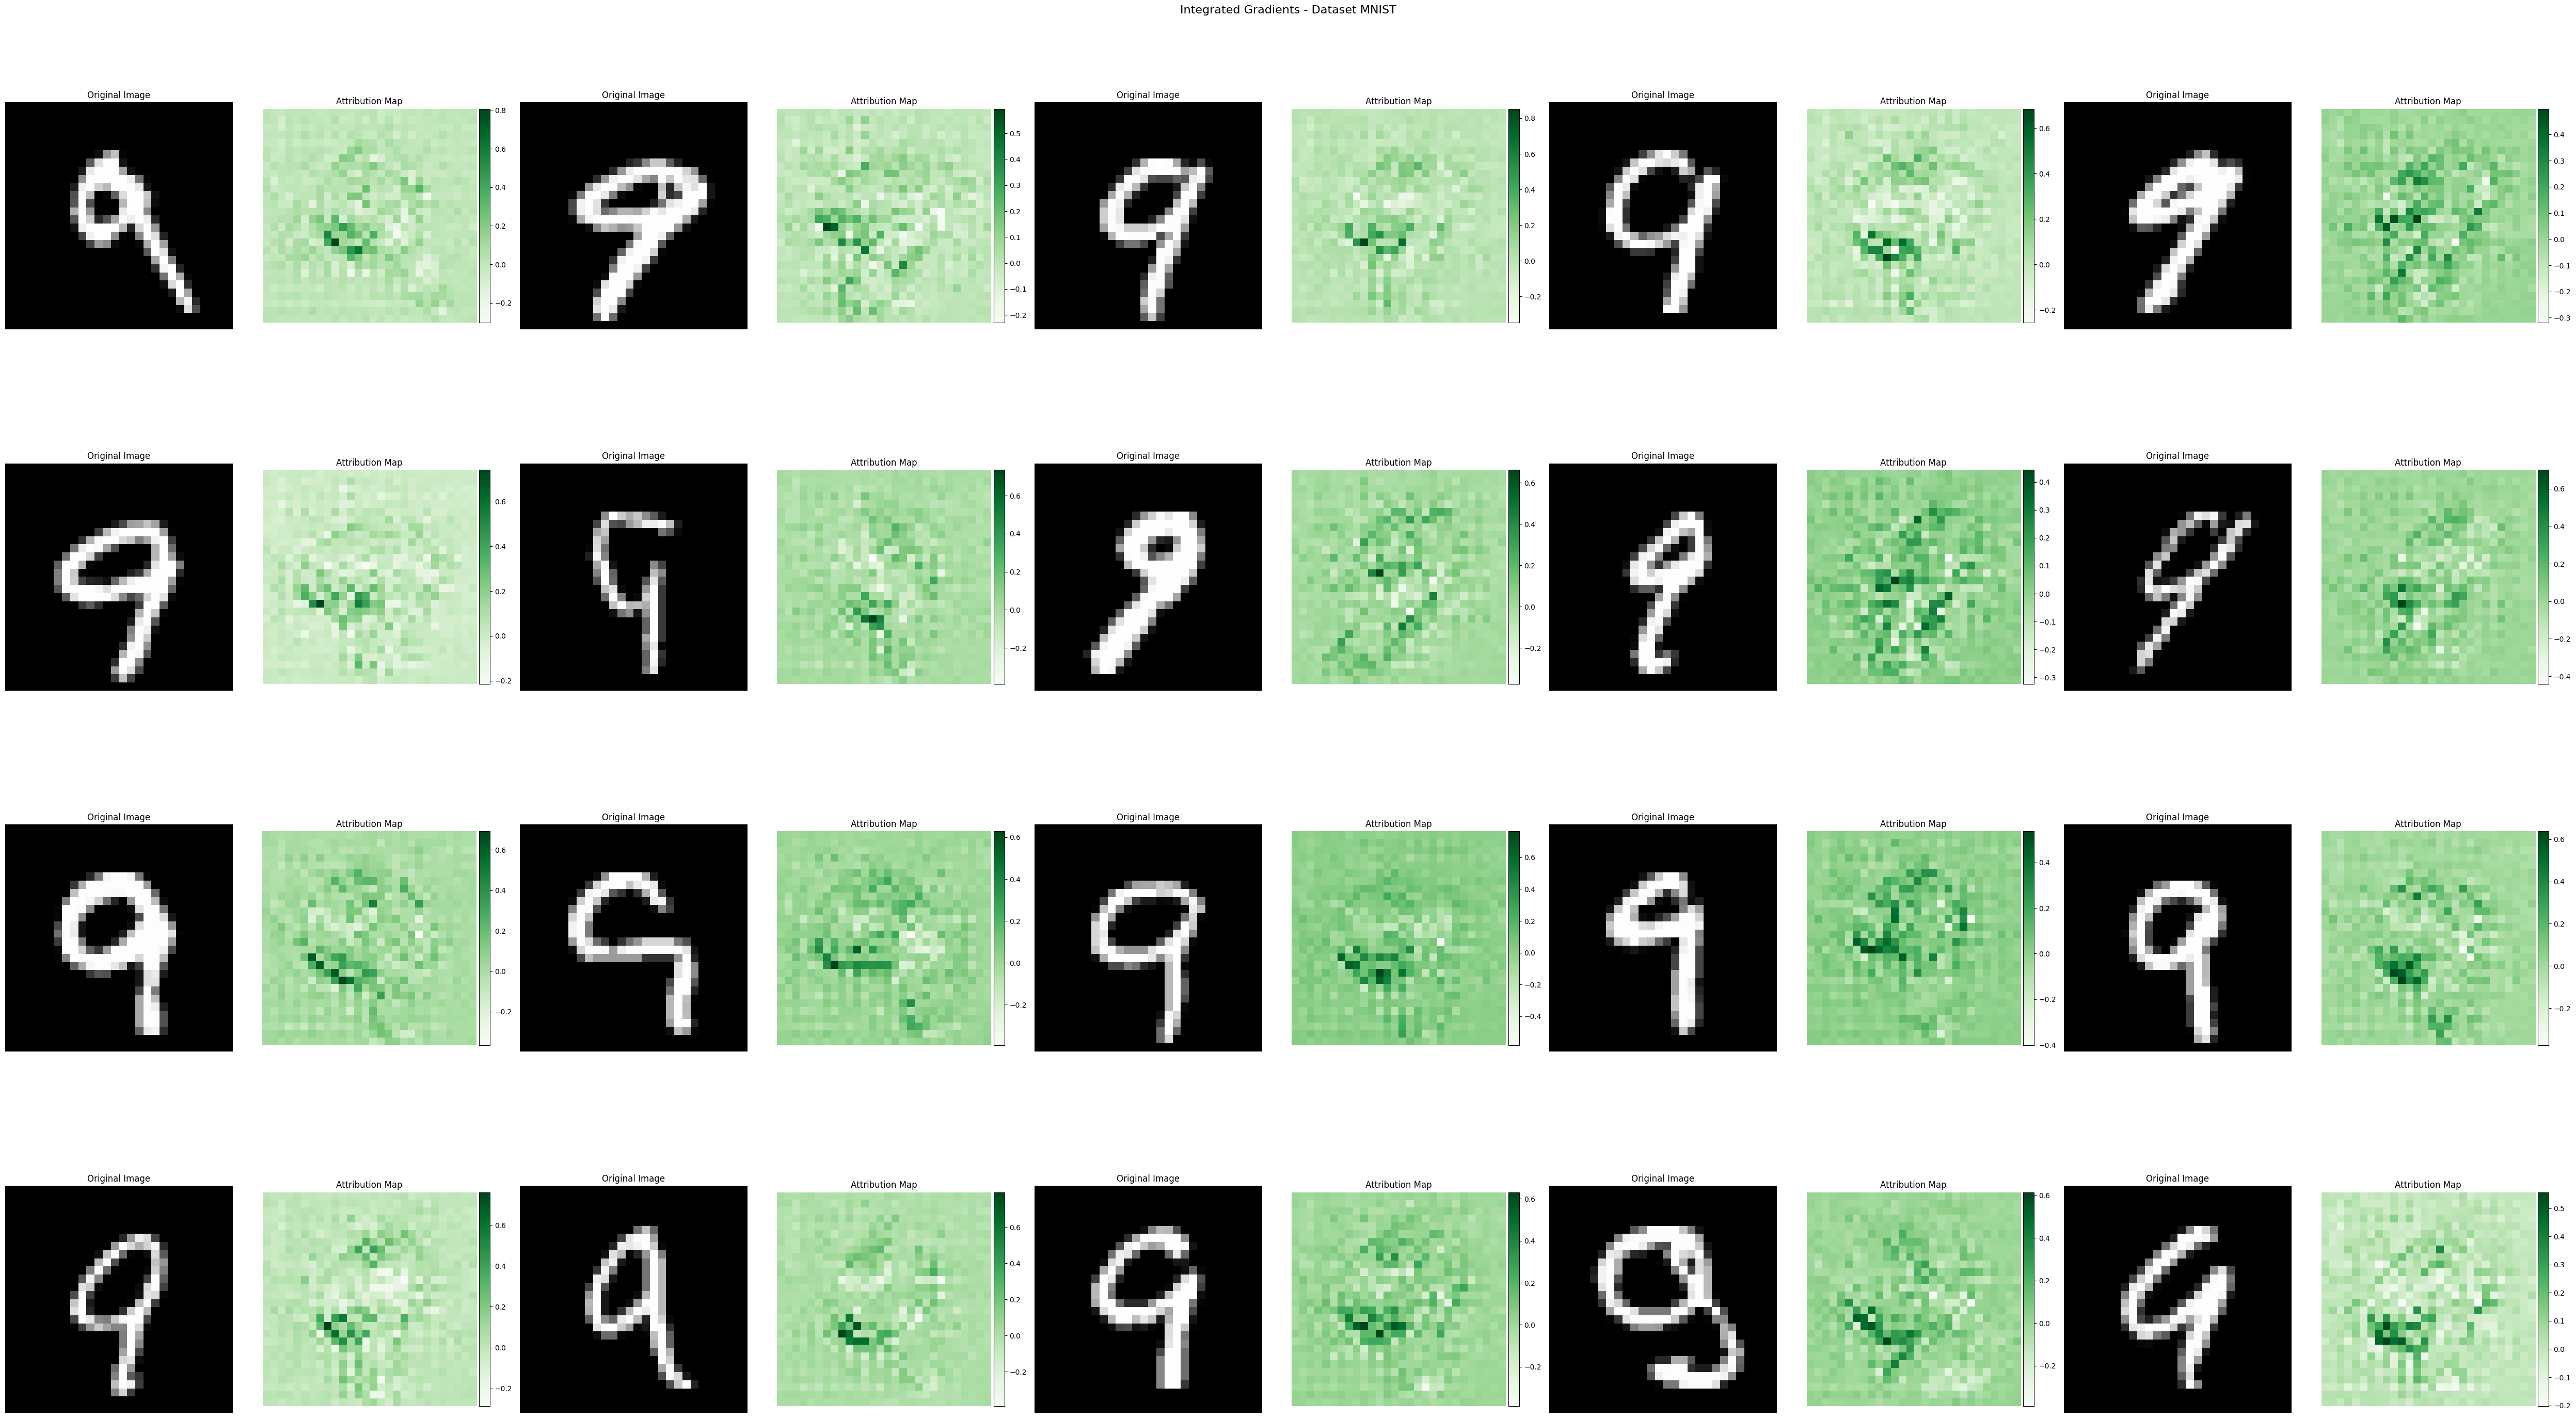

In [177]:
# Create a flat list of images to match the order of attributions
selected_images_list = [img for _, imgs in selected_images.items() for img in imgs]

# Create a figure with 5 columns and 4 rows
fig, axes = plt.subplots(nrows=4, ncols=5*2, figsize=(50, 30)) # 5*2 because each image has a pair (original and attribution)
fig.suptitle(f'Integrated Gradients - Dataset MNIST', fontsize=16)

# Iterate over the attributions and corresponding images
for idx, (attributions, image) in enumerate(zip(attributions_list, selected_images_list)):
    row = idx // 5
    col = (idx % 5) * 2  # Multiplying by 2 to accommodate both the image and its attribution side by side
    
    attr_reshaped = attributions.squeeze().cpu().detach().numpy().reshape(28, 28, 1)
    img_reshaped = image.unsqueeze(0).squeeze().cpu().detach().numpy().reshape(28, 28, 1)

    # Display the original image
    axes[row, col].imshow(img_reshaped, cmap='gray')
    axes[row, col].set_title("Original Image")
    axes[row, col].axis('off')

    # Display the attribution
    im = axes[row, col+1].imshow(attr_reshaped, 
                                 cmap='Greens', 
                                 vmin=attr_reshaped.min(), 
                                 vmax=attr_reshaped.max())
    axes[row, col+1].set_title("Attribution Map")
    axes[row, col+1].axis('off')

    # Colorbar for the attribution map
    divider = make_axes_locatable(axes[row, col+1])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, ax=axes[row, col+1], cax=cax, orientation='vertical')

_ = plt.tight_layout()
_ = plt.savefig(f'./AttributionsMaps/Digits/integrated_gradients_{chosen_digit}.png', bbox_inches='tight', dpi=300)
_ = plt.show()

# NoiseTunnel with Captum

**NoiseTunnel** is an interpretability technique utilized in deep learning to enhance the robustness and stability of attribution methods. It is a part of the `Captum` library, a collection of algorithms designed to provide insights and understanding into neural network models.

## Overview

NoiseTunnel wraps around existing attribution algorithms and adds Gaussian noise to inputs multiple times, re-computing attributions each time. By averaging these noisy attributions, it provides a smoother and more robust interpretation, especially useful for understanding features that might be artifacts or are not consistently important across slight input variations.

## Article Reference

For a deeper understanding and the foundational principles behind NoiseTunnel, refer to the original article:  
[Dombrowski, R. K., Alber, M., & Anders, C. J. (2019). Explanations can be manipulated and geometry is to blame. arXiv preprint arXiv:1906.07983.](https://arxiv.org/abs/1906.07983)

## Method Goals and Functionality

- **Robustness**: Provides more stable attributions by considering variations in the input.
- **Enhancement**: Enhances other attribution methods by wrapping around them and adding noise.
- **Artifact Identification**: Helps in identifying features that might be artifacts or inconsistently important.

/tmp/ipykernel_3275/3411717146.py:41: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  _ = plt.savefig(f'./AttributionsMaps/Digits/noise_tunnel_{chosen_digit}.png', bbox_inches='tight', dpi=300)
/tmp/ipykernel_3275/3411717146.py:41: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  _ = plt.savefig(f'./AttributionsMaps/Digits/noise_tunnel_{chosen_digit}.png', bbox_inches='tight', dpi=300)
/tmp/ipykernel_3275/3411717146.py:41: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  _ = plt.savefig(f'./AttributionsMaps/Digits/noise_tunnel_{chosen_digit}.png', bbox_inches='tight', dpi=300)
/tmp/ipykernel_3275/3411717146.py:4

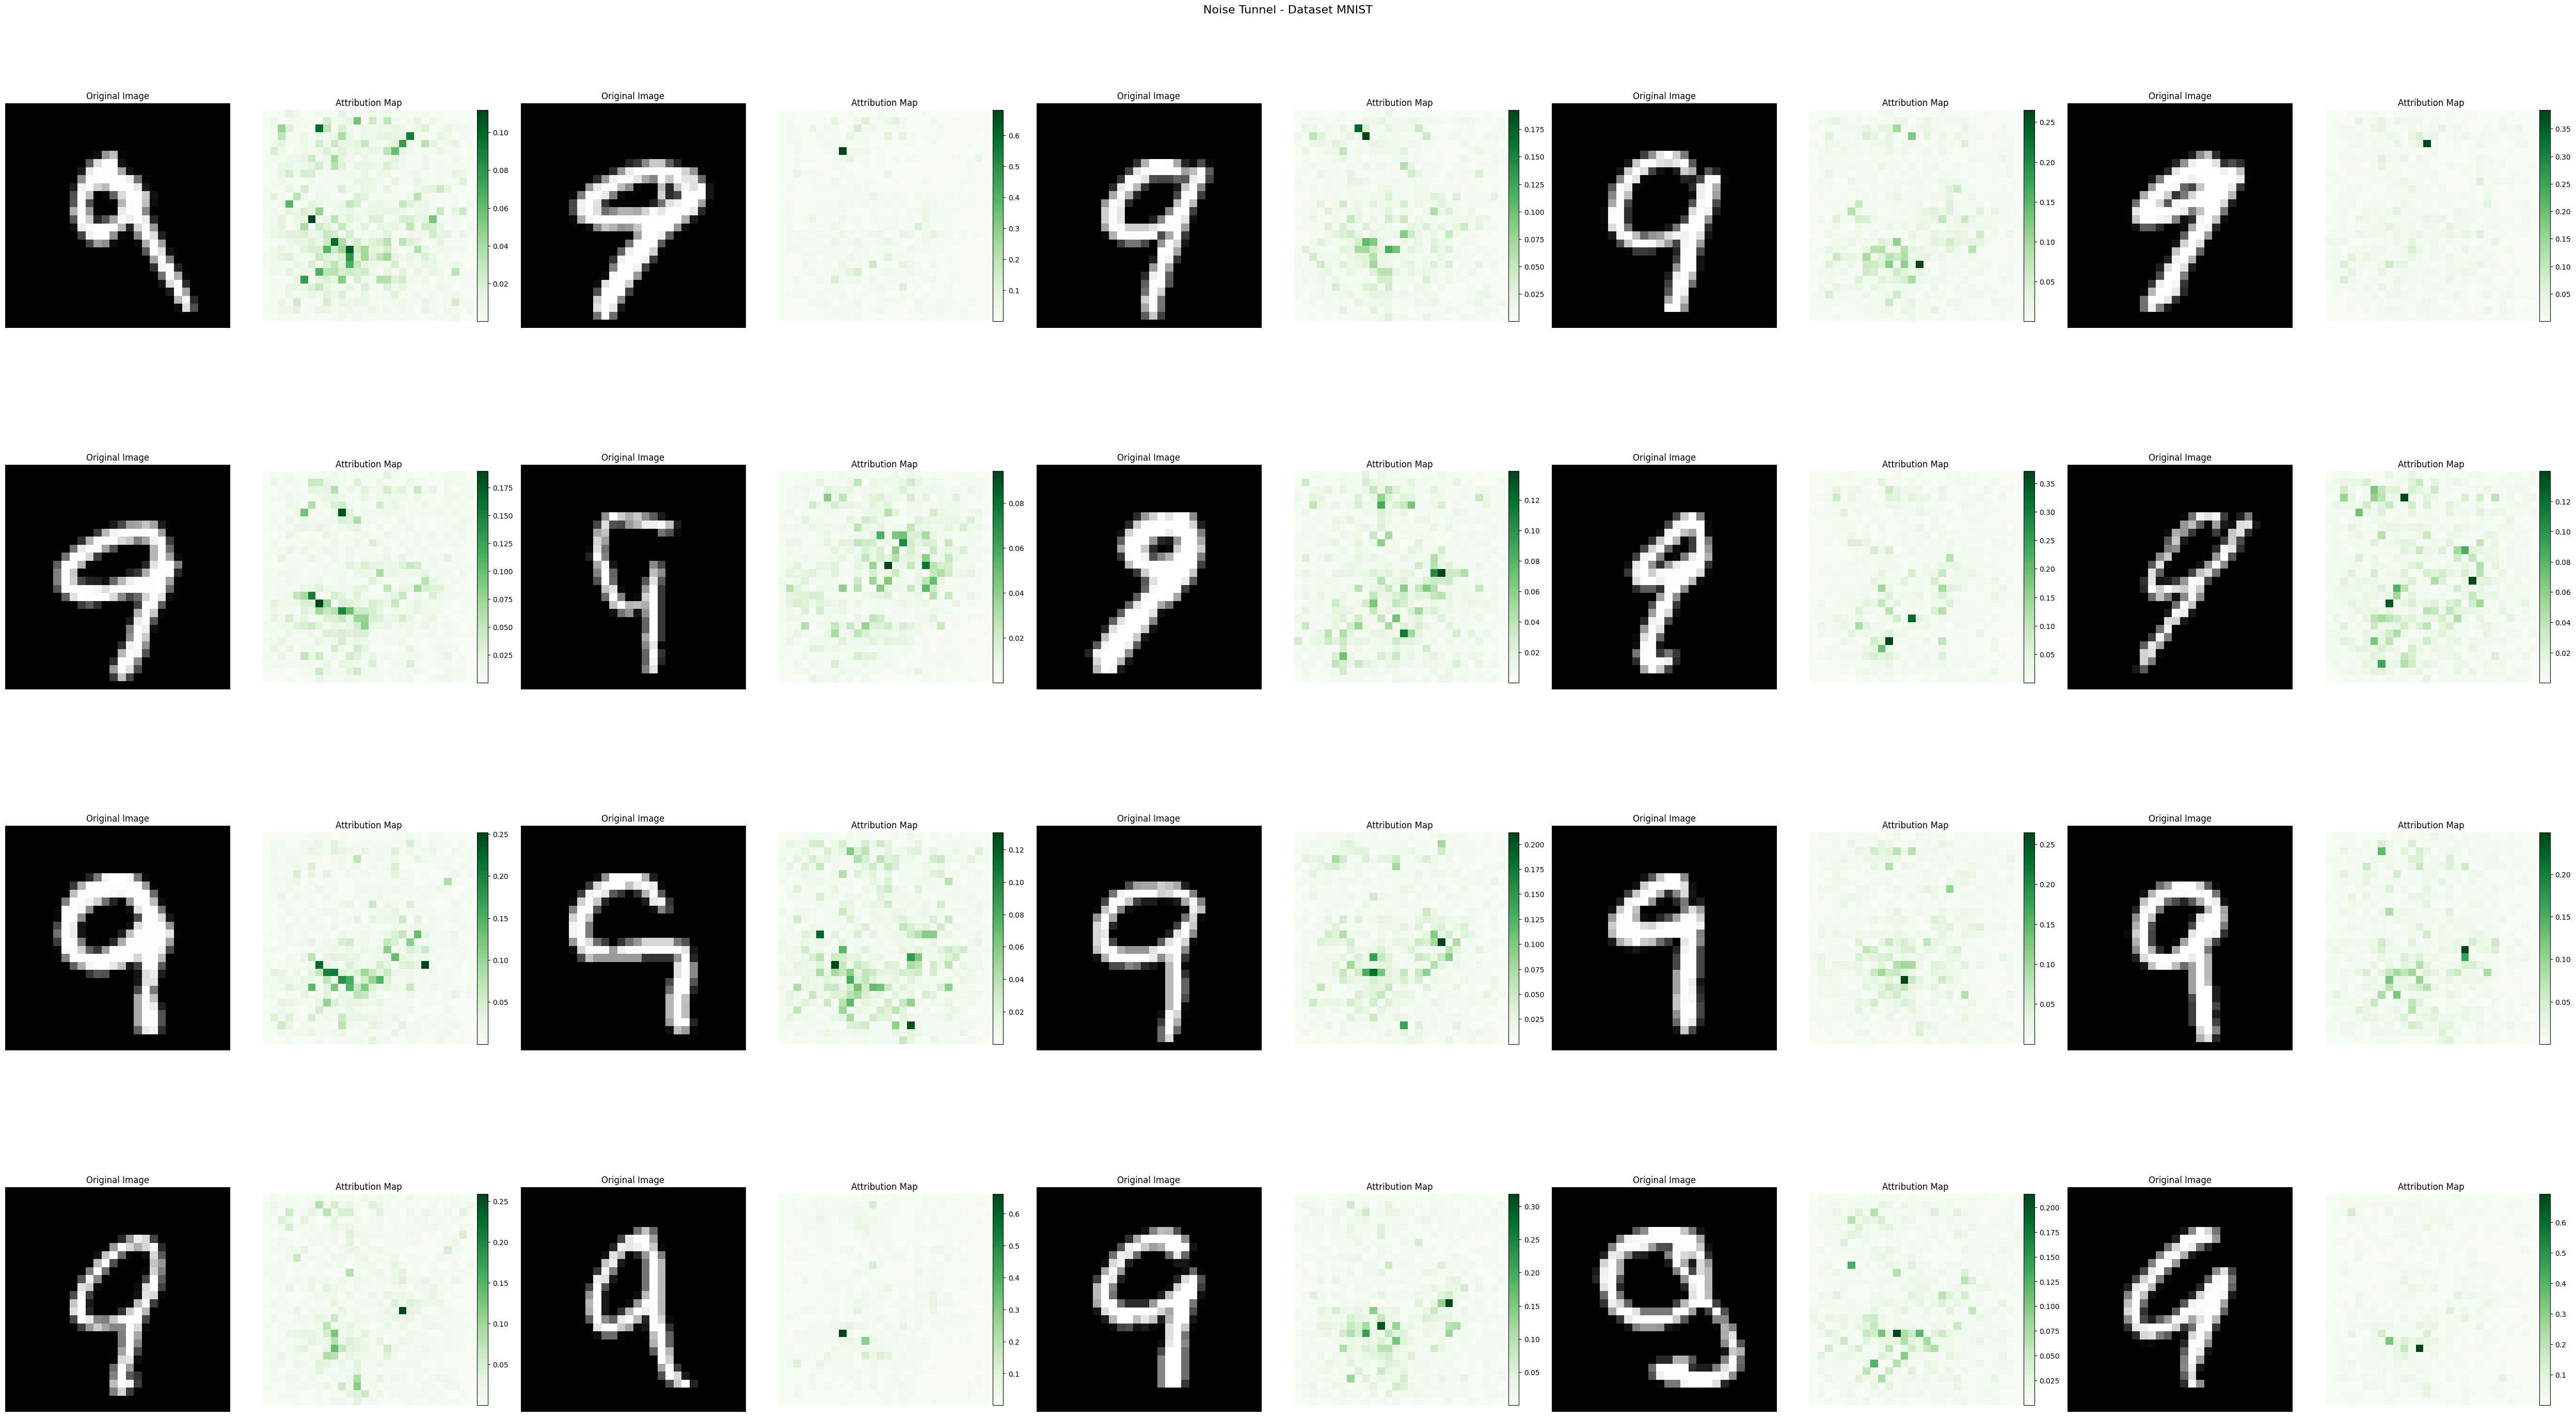

In [178]:
noise_tunnel = NoiseTunnel(integrated_gradients)
predicted_labels = [res["Predicted Label"] for res in results]

# Create a figure with 5 columns and 4 rows
fig, axes = plt.subplots(nrows=4, ncols=5*2, figsize=(50, 30)) # 5*2 because each image has a pair (original and attribution)
fig.suptitle(f'Noise Tunnel - Dataset MNIST', fontsize=16)

# Loop through each selected image
for idx, (image, predicted_label) in enumerate(zip(selected_images_list, predicted_labels)):
    
    # Generate attributions using NoiseTunnel with IntegratedGradients
    input_img = image.unsqueeze(0)  # Add batch dimension
    attributions_ig_nt = noise_tunnel.attribute(input_img, nt_samples=10, nt_type='smoothgrad_sq', target=predicted_label)

    # Prepare the reshaped attribution and image for visualization
    attr_reshaped = attributions_ig_nt.squeeze().cpu().detach().numpy().reshape(28, 28, 1)
    img_reshaped = image.unsqueeze(0).squeeze().cpu().detach().numpy().reshape(28, 28, 1)

    row = idx // 5
    col = (idx % 5) * 2  # Multiplying by 2 to accommodate both the image and its attribution side by side

    # Display the original image
    axes[row, col].imshow(img_reshaped, cmap='gray')
    axes[row, col].set_title("Original Image")
    axes[row, col].axis('off')

    # Display the attribution
    im = axes[row, col+1].imshow(attr_reshaped, 
                                 cmap='Greens', 
                                 vmin=attr_reshaped.min(), 
                                 vmax=attr_reshaped.max())
    axes[row, col+1].set_title("Attribution Map")
    axes[row, col+1].axis('off')

    # Colorbar for the attribution map
    divider = make_axes_locatable(axes[row, col+1])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, ax=axes[row, col+1], cax=cax, orientation='vertical')

_ = plt.tight_layout()
_ = plt.savefig(f'./AttributionsMaps/Digits/noise_tunnel_{chosen_digit}.png', bbox_inches='tight', dpi=300)
_ = plt.show()

# GradientShap with Captum

**GradientShap** is an advanced interpretability technique in the realm of deep learning. It combines ideas from both Shapley values and gradients to provide a unified method to compute feature importances. This method is part of the `Captum` library, which offers a collection of algorithms aimed at providing model interpretability and understanding.

## Overview

GradientShap is a method that seeks to explain the output of neural network models by assigning each feature an importance value. It does so by computing the gradients of the expected model output with respect to the input features over multiple perturbed versions of the input, which are combined with Shapley values.

## Article Reference

For an in-depth understanding and the foundational principles behind GradientShap, one can refer to the original article:  
[Lundberg, S. M., & Lee, S. I. (2017). A unified approach to interpreting model predictions. In Advances in neural information processing systems (pp. 4765-4774).](https://arxiv.org/abs/1705.07874)

## Method Goals and Functionality

- **Unified Approach**: Combines the strengths of both Shapley values and gradients.
- **Feature Importance**: Provides a measure of how each feature influences the model's prediction.
- **Consistency**: Ensures that if a model changes such that it relies more on a feature, then the attributed importance of that feature should not decrease.

/tmp/ipykernel_3275/1183053789.py:52: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  _ = plt.savefig(f'./AttributionsMaps/Digits/gradient_shap_{chosen_digit}.png', bbox_inches='tight', dpi=300)
/tmp/ipykernel_3275/1183053789.py:52: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  _ = plt.savefig(f'./AttributionsMaps/Digits/gradient_shap_{chosen_digit}.png', bbox_inches='tight', dpi=300)
/tmp/ipykernel_3275/1183053789.py:52: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  _ = plt.savefig(f'./AttributionsMaps/Digits/gradient_shap_{chosen_digit}.png', bbox_inches='tight', dpi=300)
/tmp/ipykernel_3275/1183053789.p

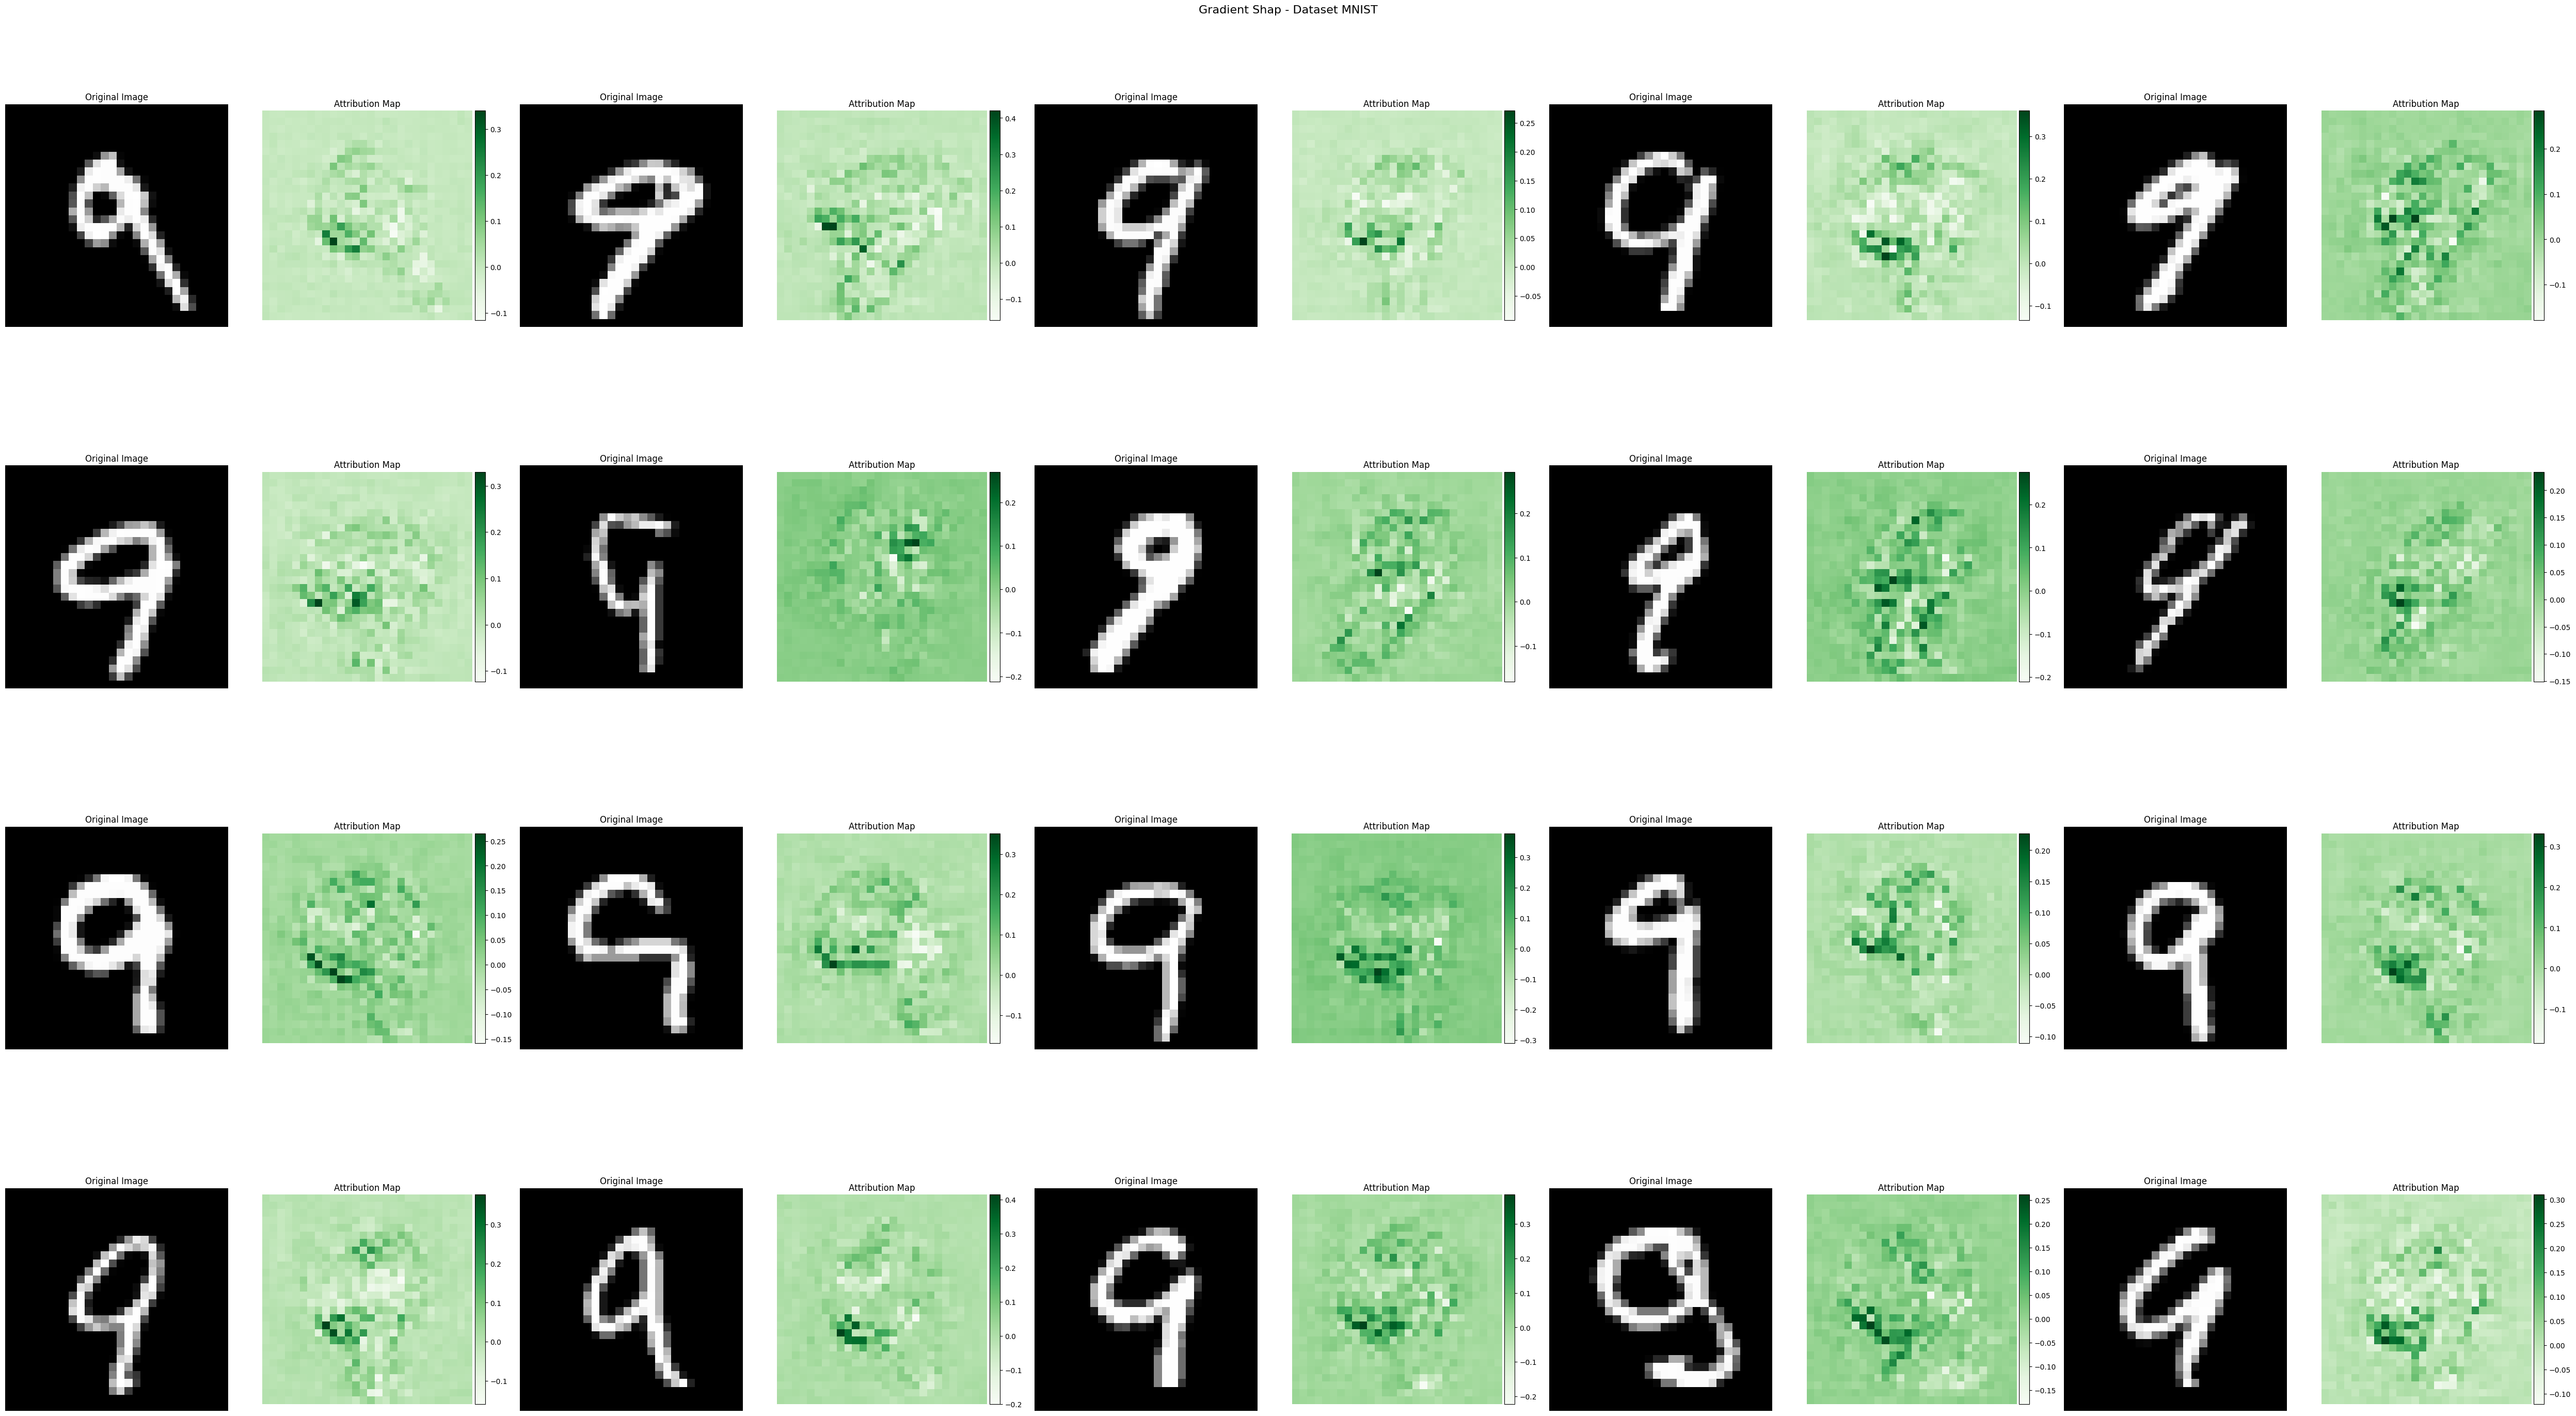

In [179]:
# Create a figure with 5 columns and 4 rows
fig, axes = plt.subplots(nrows=4, ncols=5*2, figsize=(50, 30))  # 5*2 because each image has a pair (original and attribution)
fig.suptitle(f'Gradient Shap - Dataset MNIST', fontsize=16)

gradient_shap = GradientShap(model)
# Set random seeds for reproducibility
torch.manual_seed(0)
np.random.seed(0)

# Loop through each selected image
for idx, (image, predicted_label) in enumerate(zip(selected_images_list, predicted_labels)):
    
    # Prepare the image for model
    input_img = image.unsqueeze(0)  # Add batch dimension
    
    # Defining baseline distribution of images for GradientShap
    rand_img_dist = torch.cat([input_img * 0, input_img * 1])
    
    # Generate attributions using GradientShap
    attributions_gs = gradient_shap.attribute(input_img,
                                              n_samples=50,
                                              stdevs=0.0001,
                                              baselines=rand_img_dist,
                                              target=predicted_label)
    
    # Prepare the reshaped attribution and image for visualization
    attr_reshaped = attributions_gs.squeeze().cpu().detach().numpy().reshape(28, 28, 1)
    img_reshaped = image.unsqueeze(0).squeeze().cpu().detach().numpy().reshape(28, 28, 1)

    row = idx // 5
    col = (idx % 5) * 2  # Multiplying by 2 to accommodate both the image and its attribution side by side

    # Display the original image
    axes[row, col].imshow(img_reshaped, cmap='gray')
    axes[row, col].set_title("Original Image")
    axes[row, col].axis('off')

    # Display the attribution
    im = axes[row, col+1].imshow(attr_reshaped, 
                                 cmap='Greens', 
                                 vmin=attr_reshaped.min(), 
                                 vmax=attr_reshaped.max())
    axes[row, col+1].set_title("Attribution Map")
    axes[row, col+1].axis('off')

    # Colorbar for the attribution map
    divider = make_axes_locatable(axes[row, col+1])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, ax=axes[row, col+1], cax=cax, orientation='vertical')

_ = plt.tight_layout()
_ = plt.savefig(f'./AttributionsMaps/Digits/gradient_shap_{chosen_digit}.png', bbox_inches='tight', dpi=300)
_ = plt.show()


# Occlusion with Captum

**Occlusion** is a model interpretability technique used to understand the contribution of each feature (or group of features) to a model's predictions. This method is part of the `Captum` library, which offers a suite of algorithms designed to provide insights and understanding into neural network models.

## Overview

Occlusion works by systematically occluding (or masking) parts of the input and observing the effect on the model's output. By sliding a window (or patch) across the input and replacing its content with a baseline value, we can measure how much each region of the input contributes to the prediction.

## Article Reference

For a deeper dive and foundational principles behind Occlusion, one can refer to the following article:  
[Zeiler, M. D., & Fergus, R. (2014). Visualizing and understanding convolutional networks. In European conference on computer vision (pp. 818-833). Springer, Cham.](https://arxiv.org/abs/1311.2901)

## Method Goals and Functionality

- **Feature Importance**: Identifies which parts of the input (e.g., regions of an image) are most influential in the model's prediction.
- **Model Debugging**: Helps in understanding and debugging model behaviors by highlighting influential regions.
- **Transparency**: Provides a visual way to understand how different input regions affect the output.

/tmp/ipykernel_3275/432204035.py:44: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  _ = plt.savefig(f'./AttributionsMaps/Digits/occlusion_{chosen_digit}.png', bbox_inches='tight', dpi=300)
/tmp/ipykernel_3275/432204035.py:44: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  _ = plt.savefig(f'./AttributionsMaps/Digits/occlusion_{chosen_digit}.png', bbox_inches='tight', dpi=300)
/tmp/ipykernel_3275/432204035.py:44: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  _ = plt.savefig(f'./AttributionsMaps/Digits/occlusion_{chosen_digit}.png', bbox_inches='tight', dpi=300)
/tmp/ipykernel_3275/432204035.py:44: Matplotlib

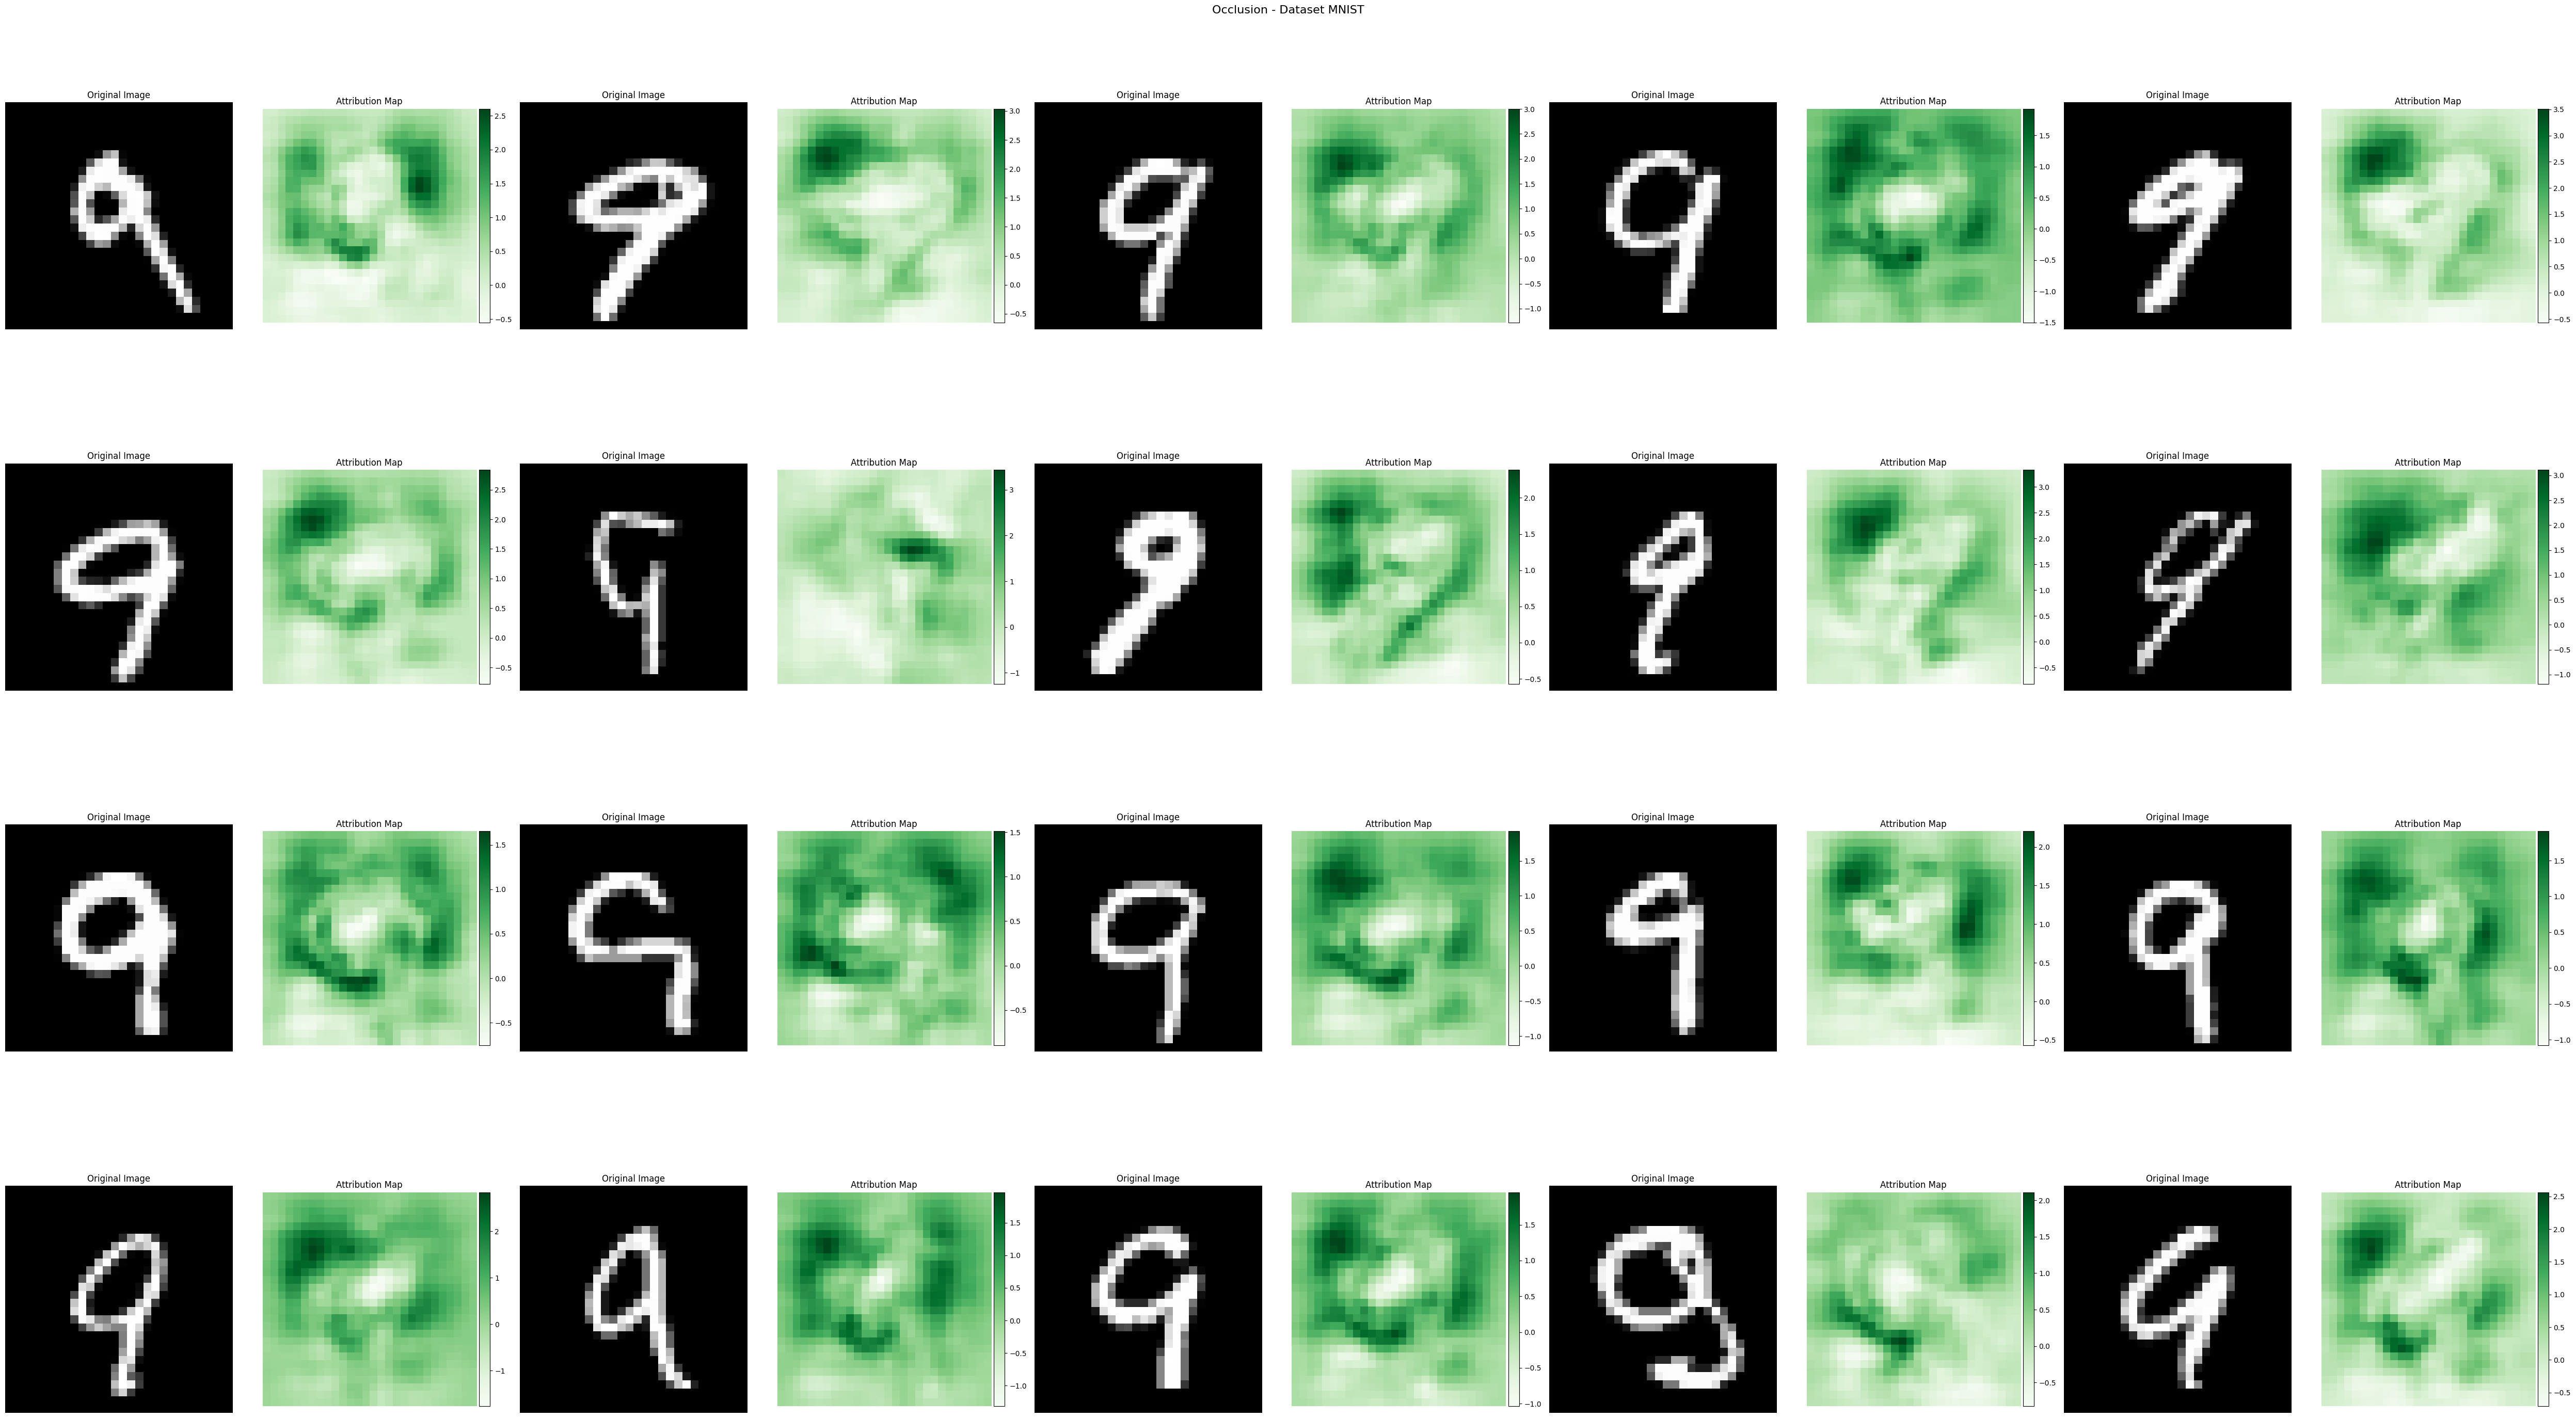

In [180]:
# Create a figure with 5 columns and 4 rows
fig, axes = plt.subplots(nrows=4, ncols=5*2, figsize=(50, 30))  # 5*2 because each image has a pair (original and attribution)
fig.suptitle(f'Occlusion - Dataset MNIST', fontsize=16)

occlusion = Occlusion(model)

# Loop through each selected image
for idx, (image, predicted_label) in enumerate(zip(selected_images_list, predicted_labels)):

    # Generate attributions using Occlusion
    input_img = image.unsqueeze(0)  # Add batch dimension
    attributions_occ = occlusion.attribute(input_img,
                                           strides=(1, 1, 1),
                                           target=predicted_label,
                                           sliding_window_shapes=(1, 2, 2),
                                           baselines=0)

    # Prepare the reshaped attribution and image for visualization
    attr_reshaped = attributions_occ.squeeze().cpu().detach().numpy().reshape(28, 28, 1)
    img_reshaped = image.unsqueeze(0).squeeze().cpu().detach().numpy().reshape(28, 28, 1)

    row = idx // 5
    col = (idx % 5) * 2  # Multiplying by 2 to accommodate both the image and its attribution side by side

    # Display the original image
    axes[row, col].imshow(img_reshaped, cmap='gray')
    axes[row, col].set_title("Original Image")
    axes[row, col].axis('off')

    # Display the attribution
    im = axes[row, col+1].imshow(attr_reshaped, 
                                 cmap='Greens', 
                                 vmin=attr_reshaped.min(), 
                                 vmax=attr_reshaped.max())
    axes[row, col+1].set_title("Attribution Map")
    axes[row, col+1].axis('off')

    # Colorbar for the attribution map
    divider = make_axes_locatable(axes[row, col+1])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, ax=axes[row, col+1], cax=cax, orientation='vertical')

_ = plt.tight_layout()
_ = plt.savefig(f'./AttributionsMaps/Digits/occlusion_{chosen_digit}.png', bbox_inches='tight', dpi=300)
_ = plt.show()